# DCAN Lab Introduction to Command Line Image Math

## Topics

* What makes an image?


* What are some operations on images?

    * Images and Numbers

    * Images and other Images
    
    * Transformations


* What kind of images are there in MRI research?

    * Anatomy
    
    * Functional
    
    * Labels


* Common DCAN Tools

    * fsl
    
    * FreeSurfer
       
    * ANTs
    


## What Makes An Image?

In this context we will always be talking about *digital images*, the way that they are represented on a computer.  Starting this intro with 2-dimensional images, a standard digital image is represented on a computer by a grid (or matrix/array) of numbers.


In [1]:
%matplotlib inline
# python visualization and mathematics packages
from matplotlib import pyplot as plt
import numpy as np
from pprint import pprint

# intialize a grid, we will call it "grid1"
m = 6; n = 6
grid1 = np.zeros((m, n), dtype=int)
grid1[:, :3] = 1

# initialize a second grid, "grid2"
m = 3; n = 3
even = np.array(m * [1, 0])
odd = even[::-1]
grid2 = np.row_stack(n * (even, odd))

# print the grids out as data/matrices
pprint(grid1.tolist())
print('')
pprint(grid2.tolist())

[[1, 1, 1, 0, 0, 0],
 [1, 1, 1, 0, 0, 0],
 [1, 1, 1, 0, 0, 0],
 [1, 1, 1, 0, 0, 0],
 [1, 1, 1, 0, 0, 0],
 [1, 1, 1, 0, 0, 0]]

[[1, 0, 1, 0, 1, 0],
 [0, 1, 0, 1, 0, 1],
 [1, 0, 1, 0, 1, 0],
 [0, 1, 0, 1, 0, 1],
 [1, 0, 1, 0, 1, 0],
 [0, 1, 0, 1, 0, 1]]


Above you can see the shape of the grids we have created.  Notice grid1 is split half and half between 1 and 0, grid2 is alternating 1s and 0s.  This notation may be novel, but it corresponds quite nicely to the elements of a matrix, or an excel spreadsheet, csv, whatever format you may be used to reading in tabular data, it is organized by two indices: a row index and a column index which together map each element.

Let's see how these numbers look as a images:

Text(0.5,1,'grid2')

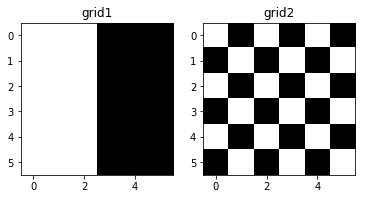

In [2]:
plt.subplot(1, 2, 1)
plt.imshow(grid1, cmap='gray')
plt.title('grid1')
plt.subplot(1, 2, 2)
plt.imshow(grid2, cmap='gray')
plt.title('grid2')

Notice that wherever we had a 1, the image shows a white square.  Wherever we had a 0, the image shows a black square.  Whether the number or the visible representation, these are "pixels".

If we were discussing photographs such as taken on a digital camera, each pixel would actually have three values associated: R, G, and B.  In the context of MRI, we are only concerned with grayscale images.


## What Are Some Operations on Images?

Here we will discuss mathematical operations which can be performed on images.

### Images and Numbers

Given some number $x$, and another number $a$, I can write some simple equations like:

$$x + a = 6 \\
x - a = 1 \\
x \times a = 6 \\
x ^ a = 9$$

Which you will recognize as addition, subtraction, multiplication and exponentiation.

For some image $I$, and a number $a$, I can carry out all of the same operations, for example, I can add $a$ to grid1, the half and half grid from before:

$$ a + I = ?$$

In [3]:
# a = 2
I = grid1; a = 2
# add 2 to the image.
J = a + I
pprint(J.tolist())

[[3, 3, 3, 2, 2, 2],
 [3, 3, 3, 2, 2, 2],
 [3, 3, 3, 2, 2, 2],
 [3, 3, 3, 2, 2, 2],
 [3, 3, 3, 2, 2, 2],
 [3, 3, 3, 2, 2, 2]]


Notice that the value of each element in grid1 has increased by 2!  We call these *elementwise* operations, where the normal mathematical operation: addition, multiplication, etc. is carried out individually on each pixel/element of the image:

$$ J_{n, m} = a + I_{n, m} $$

where $I_{n, m}$ is the element in row n, column m, of $I$ 

Adding 2 to an image is the same as adding 2 to every pixel, multiplying an image by 2 is the same as multiplying every pixel by 2.  In fact, even fancy operations like log, exponents, or trig functions obey this same rule.

Let's take a look at the visual result for illustrative purposes:

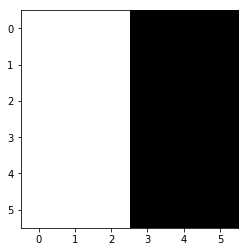

In [4]:
plt.imshow(J, cmap='gray')

Question:  Why does the image still look the same as before?

...

Answer: You must be careful when visually comparing different images to make sure they are *scaled* the same. 2 is here black because it is the *lowest* value in the image.  3 is white because it is the *highest*.  We could also scale this image from 0 to 5, and we would see some slightly different shades of gray in place of 3 and 2:

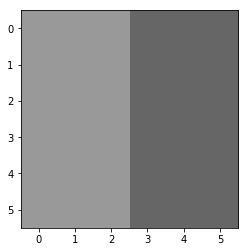

In [5]:
plt.imshow(J, cmap='gray', vmin=0, vmax=5)

### Images and other Images

Similar to before, we can also have addition, subtraction, multiplication, division, etc. between images.  For example, given an image $I$ and an image $J$ we can still have:  

$I + J = K$

where K is a new image.  To perform this operation, we *add* I and J elementwise, like so:

$$ K_{n,m} = I_{n,m} + J_{n,m} $$

Here we will add the two images from above, the checkered and the half and half:

[[2, 1, 2, 0, 1, 0],
 [1, 2, 1, 1, 0, 1],
 [2, 1, 2, 0, 1, 0],
 [1, 2, 1, 1, 0, 1],
 [2, 1, 2, 0, 1, 0],
 [1, 2, 1, 1, 0, 1]]


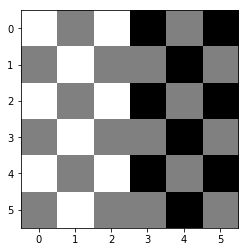

In [6]:
I = grid1; J = grid2
K = I + J
pprint(K.tolist())
plt.imshow(K, cmap='gray')

Note that there are now three distinct values in the matrix: 2, 1, 0, and three distinct gray levels in the resulting image.

### Transformations

Now we will start to get into the idea of transforming an image.  Transformations are what allow us to register images.  

#### Linear Transformations

There are 4 types of linear transformation:

* Translation

* Rotation

* Scaling

* Shearing

##### Affine Linear Transforms

Below is an illustration of each of the 4, sometimes known by slightly different names.  Here "Shearing" is "Skew", and "Differential" Scaling is used because the scaling need not be equivilent in different dimentions (hence the differential), turning the square into a rectangle.


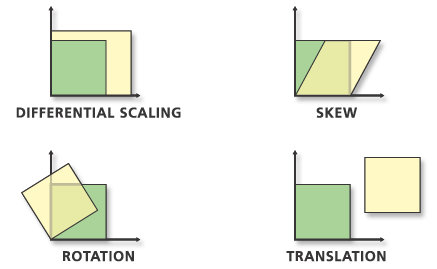

In [7]:
from IPython.display import Image
Image("img/all_4_affine.jpg")

Together these 4 transformation types make up "affine" transformations.  A single linear transformation may involve one or all of them.  It is specifically called affine when we are using or allowed to use all 4.

##### Rigid Body Linear Transforms

Translation and rotation, when considered alone, encompass "rigid body" or "euclidean" transformations.  A translation is a shift of the object from point A to point B.  A rotation is performed about the origin.  Transformations involving only these two are called "rigid body" because the shape and size of the object are constant.  The images below illustrate what these two transforms look like for a square when performed in succession.

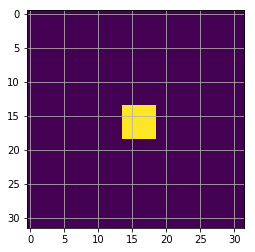

In [ ]:
from ipywidgets import interact
import ipywidgets as widgets
from skimage.transform import warp


N = 32
square = np.zeros((N, N))
square[N//2-2:N//2+3, N//2-2:N//2+3] = 1


def f(tx, ty, θ):
    global square
    mat = np.array([
        [np.cos(θ), -np.sin(θ), tx],
        [np.sin(θ), np.cos(θ), ty],
        [0, 0, 1] # rigid body
    ])
    img = warp(square, mat, output_shape=square.shape)
    plt.imshow(img)
    plt.grid()


x = widgets.IntSlider(min=-5, max=5)
y = widgets.IntSlider(min=-5, max=5)
t = widgets.FloatSlider(min=0, max=2*np.pi)
plot = interact(f, tx=x, ty=y, θ=t)

Notice that the square ends up in a different location based on the order of the two transformations.  This is because objects further from the origin will cover a longer arc when rotating.  The main takeaway should be that order matters, and transformations cannot, in general, be swapped around without consequence.

#### Nonlinear Transformations

To be continued...